In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import pickle
import joblib
import os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Functions

In [2]:
def save_model(model, model_path):
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

def load_model(model_path):
    with open(model_path, 'rb') as f:
        return pickle.load(f)

def load_dataset(folder_name):
    with open(f'../data/{folder_name}/train.pkl', 'rb') as f:
        X_train, y_train = pickle.load(f)
    with open(f'../data/{folder_name}/val.pkl', 'rb') as f:
        X_val, y_val = pickle.load(f)
    with open(f'../data/{folder_name}/test.pkl', 'rb') as f:
        X_test, y_test = pickle.load(f)
    
    scaler_y = None
    if folder_name in ['norm', 'hot_norm']:
        with open(f'../data/{folder_name}/scaler_y.pkl', 'rb') as f:
            scaler_y = pickle.load(f)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler_y

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, scaler_y=None, dataset_name=''):
    performances = []
    data_splits = [(X_train, y_train, 'train'), (X_val, y_val, 'val'), (X_test, y_test, 'test')]
    
    for x, y, nsplit in data_splits:
        preds = model.predict(x)
        r2 = r2_score(y, preds)
        rmse = np.sqrt(mean_squared_error(y, preds))
        mae = mean_absolute_error(y, preds)
        
        # Update model name to include number of neighbors if KNN
        model_name = model.__class__.__name__
        if model_name == 'KNeighborsRegressor':
            model_name += f" (k={model.n_neighbors})"
        
        performances.append({
            'model': model_name,
            'dataset': dataset_name,
            'split': nsplit,
            'rmse': rmse.round(4),
            'mae': mae.round(4),
            'r2': r2.round(4),
            'inversed': False
        })
        
        if scaler_y is not None:
            preds_original = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
            y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
            
            r2_original = r2_score(y_original, preds_original)
            rmse_original = np.sqrt(mean_squared_error(y_original, preds_original))
            mae_original = mean_absolute_error(y_original, preds_original)
            
            performances.append({
                'model': model_name,
                'dataset': dataset_name,
                'split': nsplit,
                'rmse': rmse_original.round(4),
                'mae': mae_original.round(4),
                'r2': r2_original.round(4),
                'inversed': True
            })
    
    return performances


# Fit models

In [3]:
# Initialize a list to store all performances
all_performances = []

# List of dataset names and their corresponding folder names
dataset_names = ['original', 'hot', 'norm', 'hot_norm']

# Directory to save models
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# KNN

In [4]:
# Load each dataset, fit the KNN models, and store the results
for dataset_name in dataset_names:
    # Skip the dataset if it is not "hot" or "hot_norm"
    if dataset_name not in ['hot', 'hot_norm']:
        continue
    
    X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = load_dataset(dataset_name)
    
    for k in [5, 10, 20, 30, 100]:  # Choosing number of neighbors for KNN
        model_path = os.path.join(model_dir, f'knn_{k}_neighbors_{dataset_name}.pkl')
        
        if os.path.exists(model_path):
            knn = load_model(model_path)
            print(f"Loaded KNeighborsRegressor model with {k} neighbors from {model_path}")
        else:
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train, y_train)
            save_model(knn, model_path)
            print(f"Trained and saved KNeighborsRegressor model with {k} neighbors to {model_path}")
        
        performances = evaluate_model(knn, X_train, X_val, X_test, y_train, y_val, y_test, scaler_y=scaler_y, dataset_name=dataset_name)
        all_performances.extend(performances)

Loaded KNeighborsRegressor model with 5 neighbors from ../models/knn_5_neighbors_hot.pkl
Loaded KNeighborsRegressor model with 10 neighbors from ../models/knn_10_neighbors_hot.pkl
Loaded KNeighborsRegressor model with 20 neighbors from ../models/knn_20_neighbors_hot.pkl
Loaded KNeighborsRegressor model with 30 neighbors from ../models/knn_30_neighbors_hot.pkl
Loaded KNeighborsRegressor model with 100 neighbors from ../models/knn_100_neighbors_hot.pkl
Loaded KNeighborsRegressor model with 5 neighbors from ../models/knn_5_neighbors_hot_norm.pkl
Loaded KNeighborsRegressor model with 10 neighbors from ../models/knn_10_neighbors_hot_norm.pkl
Loaded KNeighborsRegressor model with 20 neighbors from ../models/knn_20_neighbors_hot_norm.pkl
Loaded KNeighborsRegressor model with 30 neighbors from ../models/knn_30_neighbors_hot_norm.pkl
Loaded KNeighborsRegressor model with 100 neighbors from ../models/knn_100_neighbors_hot_norm.pkl


# Forest

# NEED TO MAKE "ORIGINAL" AND "NORM" DATA WITH NUMER CATEGORICAL INSTEAD UGH

In [16]:
# Load each dataset, fit the RandomForestRegressor models, and store the results
for dataset_name in dataset_names:
    X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = load_dataset(dataset_name)
    
 # Skip the dataset if it is not "hot" or "hot_norm"
    #if dataset_name not in ['hot', 'hot_norm']:
    #    continue

    # Define model parameters
    model_path = os.path.join(model_dir, f'random_forest_max_depth_2_{dataset_name}.pkl')
    
    if os.path.exists(model_path):
        rf = load_model(model_path)
        print(f"Loaded RandomForestRegressor model with max_depth=2 from {model_path}")
    else:
        rf = RandomForestRegressor(max_depth=2, random_state=0)
        rf.fit(X_train, y_train)
        save_model(rf, model_path)
        print(f"Trained and saved RandomForestRegressor model with max_depth=2 to {model_path}")
    
    performances = evaluate_model(rf, X_train, X_val, X_test, y_train, y_val, y_test, scaler_y=scaler_y, dataset_name=dataset_name)
    all_performances.extend(performances)

ValueError: could not convert string to float: 'Entire home/apt'

In [6]:
# Assuming `all_performances` is the list of performance metrics
perf_df = pd.DataFrame(all_performances)

# Add a new column "plot_name" which is a combination of "model" and "dataset"
perf_df['plot_name'] = perf_df['model'] + ' (' + perf_df['dataset'] + ')'

# Split the DataFrame into inversed and non-inversed
inversed_df = perf_df[perf_df['inversed'] == True]
NOT_inversed_df = perf_df[perf_df['inversed'] == False]

In [7]:
perf_df

,model,dataset,split,rmse,mae,r2,inversed,plot_name
0,KNeighborsRegressor (k=5),hot,train,94.1737,57.5248,0.7404,False,KNeighborsRegressor (k=5) (hot)
1,KNeighborsRegressor (k=5),hot,val,120.3263,72.3049,0.5779,False,KNeighborsRegressor (k=5) (hot)
2,KNeighborsRegressor (k=5),hot,test,121.6982,74.1907,0.5744,False,KNeighborsRegressor (k=5) (hot)
3,KNeighborsRegressor (k=10),hot,train,109.9679,67.4732,0.6461,False,KNeighborsRegressor (k=10) (hot)
4,KNeighborsRegressor (k=10),hot,val,124.2910,75.0499,0.5496,False,KNeighborsRegressor (k=10) (hot)
5,KNeighborsRegressor (k=10),hot,test,125.6527,76.9008,0.5463,False,KNeighborsRegressor (k=10) (hot)
6,KNeighborsRegressor (k=20),hot,train,121.9027,75.0856,0.5651,False,KNeighborsRegressor (k=20) (hot)
7,KNeighborsRegressor (k=20),hot,val,130.2324,79.2031,0.5055,False,KNeighborsRegressor (k=20) (hot)
8,KNeighborsRegressor (k=20),hot,test,130.5212,80.4466,0.5105,False,KNeighborsRegressor (k=20) (hot)
9,KNeighborsRegressor (k=30),hot,train,127.4669,78.9094,0.5245,False,KNeighborsRegressor (k=30) (hot)


In [11]:
# Filter the DataFrame
filtered_df = perf_df[((perf_df['dataset'] == 'hot') & (perf_df['inversed'] == False)) |
                      ((perf_df['dataset'] == 'hot_norm') & (perf_df['inversed'] == True))]


# Plot

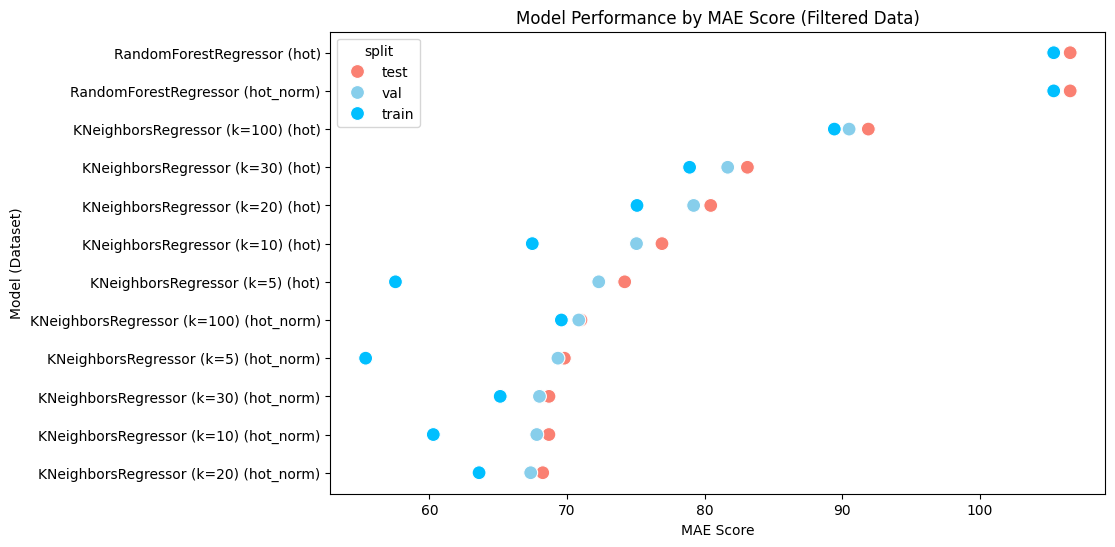

In [15]:
# Plot for Filtered Data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df.sort_values(by='mae', ascending=False), 
                y='plot_name', 
                x='mae', 
                marker='o',   # Circle markers
                s=100,        # Size of the markers
                hue='split',  # Color by split
                palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'})  # Custom color palette

# Adding plot title
plt.title('Model Performance by MAE Score (Filtered Data)')

# Adding x and y axis labels
plt.xlabel('MAE Score')
plt.ylabel('Model (Dataset)')

# Save plot
plt.savefig('../plots/filtered_models_MAE.png')
# Display the plot
plt.show()
